In [1]:
import numpy as np
import yfinance as yf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import prophet as pt
import datetime as dt
from sklearn.metrics import mean_squared_error, mean_absolute_error
sns.set_style('whitegrid')
plt.style.use("default")
%matplotlib inline
from pandas_datareader.data import DataReader
from pandas_datareader import data as pdr
yf.pdr_override()
from tensorflow.keras.models import load_model

d:\Time-series-forecasting\tsf\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


df = pd.DataFrame(listing_companies())\
search_word = 'mobile'\
result = df[df['organName'].str.contains(search_word)]\
print(result)

Vin = VIC\
Viettel = VGI\
FPT = FPT\
thế giới di động = MWG\
Petrolimex = PLC

In [2]:
start_date = dt.datetime(2022, 10, 1)
end_date = dt.datetime(2023, 9, 30)
df = pdr.get_data_yahoo('AAPL', start_date, end_date)
display(df.head())

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-10-03,138.210007,143.070007,137.690002,142.449997,141.609924,114311700
2022-10-04,145.029999,146.220001,144.259995,146.100006,145.238388,87830100
2022-10-05,144.070007,147.380005,143.009995,146.399994,145.536621,79471000
2022-10-06,145.809998,147.539993,145.220001,145.429993,144.572327,68402200
2022-10-07,142.539993,143.100006,139.449997,140.089996,139.263840,85925600


# TURTLE AGENT

In [3]:
count = int(np.ceil(len(df) * 0.1))
signals = pd.DataFrame(index=df.index)
signals['signal'] = 0.0
signals['trend'] = df['Close']
signals['RollingMax'] = (signals.trend.shift(1).rolling(count).max())
signals['RollingMin'] = (signals.trend.shift(1).rolling(count).min())
signals.loc[signals['RollingMax'] < signals.trend, 'signal'] = -1
signals.loc[signals['RollingMin'] > signals.trend, 'signal'] = 1
signals

,signal,trend,RollingMax,RollingMin
Date,,,,
2022-10-03,0.0,142.449997,NaN,NaN
2022-10-04,0.0,146.100006,NaN,NaN
2022-10-05,0.0,146.399994,NaN,NaN
2022-10-06,0.0,145.429993,NaN,NaN
2022-10-07,0.0,140.089996,NaN,NaN
...,...,...,...,...
2023-09-25,0.0,176.080002,189.699997,173.929993
2023-09-26,1.0,171.960007,189.699997,173.929993
2023-09-27,1.0,170.429993,189.699997,171.960007


In [4]:
def buy_stock(
    real_movement,
    signal,
    initial_money = 10000,
    max_buy = 1,
    max_sell = 1,
):
    """
    real_movement = actual movement in the real world
    delay = how much interval you want to delay to change our decision from buy to sell, vice versa
    initial_state = 1 is buy, 0 is sell
    initial_money = 1000, ignore what kind of currency
    max_buy = max quantity for share to buy
    max_sell = max quantity for share to sell
    """
    starting_money = initial_money
    states_sell = []
    states_buy = []
    current_inventory = 0

    def buy(i, initial_money, current_inventory):
        shares = initial_money // real_movement[i]
        if shares < 1:
            print(
                'day %d: total balances %f, not enough money to buy a unit price %f'
                % (i, initial_money, real_movement[i])
            )
        else:
            if shares > max_buy:
                buy_units = max_buy
            else:
                buy_units = shares
            initial_money -= buy_units * real_movement[i]
            current_inventory += buy_units
            print(
                'day %d: buy %d units at price %f, total balance %f'
                % (i, buy_units, buy_units * real_movement[i], initial_money)
            )
            states_buy.append(0)
        return initial_money, current_inventory

    for i in range(real_movement.shape[0] - int(0.025 * len(df))):
        state = signal[i]
        if state == 1:
            initial_money, current_inventory = buy(
                i, initial_money, current_inventory
            )
            states_buy.append(i)
        elif state == -1:
            if current_inventory == 0:
                    print('day %d: cannot sell anything, inventory 0' % (i))
            else:
                if current_inventory > max_sell:
                    sell_units = max_sell
                else:
                    sell_units = current_inventory
                current_inventory -= sell_units
                total_sell = sell_units * real_movement[i]
                initial_money += total_sell
                try:
                    invest = (
                        (real_movement[i] - real_movement[states_buy[-1]])
                        / real_movement[states_buy[-1]]
                    ) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (i, sell_units, total_sell, invest, initial_money)
                )
            states_sell.append(i)
            
    invest = ((initial_money - starting_money) / starting_money) * 100
    total_gains = initial_money - starting_money
    return states_buy, states_sell, total_gains, invest

In [5]:
states_buy, states_sell, total_gains, invest = buy_stock(df.Close, signals['signal'])

day 27: buy 1 units at price 134.869995, total balance 9865.130005
day 53: buy 1 units at price 134.509995, total balance 9730.620010
day 54: buy 1 units at price 132.369995, total balance 9598.250015
day 55: buy 1 units at price 132.300003, total balance 9465.950012
day 57: buy 1 units at price 132.229996, total balance 9333.720016
day 58: buy 1 units at price 131.860001, total balance 9201.860016
day 59: buy 1 units at price 130.029999, total balance 9071.830017
day 60: buy 1 units at price 126.040001, total balance 8945.790016
day 63: buy 1 units at price 125.070000, total balance 8820.720016
day 65: buy 1 units at price 125.019997, total balance 8695.700020
day 77, sell 1 units at price 142.529999, investment 14.005761 %, total balance 8838.230019,
day 79, sell 1 units at price 143.960007, investment 15.149585 %, total balance 8982.190025,
day 80, sell 1 units at price 145.929993, investment 16.725321 %, total balance 9128.120018,
day 84, sell 1 units at price 150.820007, investmen

C:\Users\lehun\AppData\Local\Temp\ipykernel_7204\704551773.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  state = signal[i]
C:\Users\lehun\AppData\Local\Temp\ipykernel_7204\704551773.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  shares = initial_money // real_movement[i]
C:\Users\lehun\AppData\Local\Temp\ipykernel_7204\704551773.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  initial_money -= buy_units * real_movem

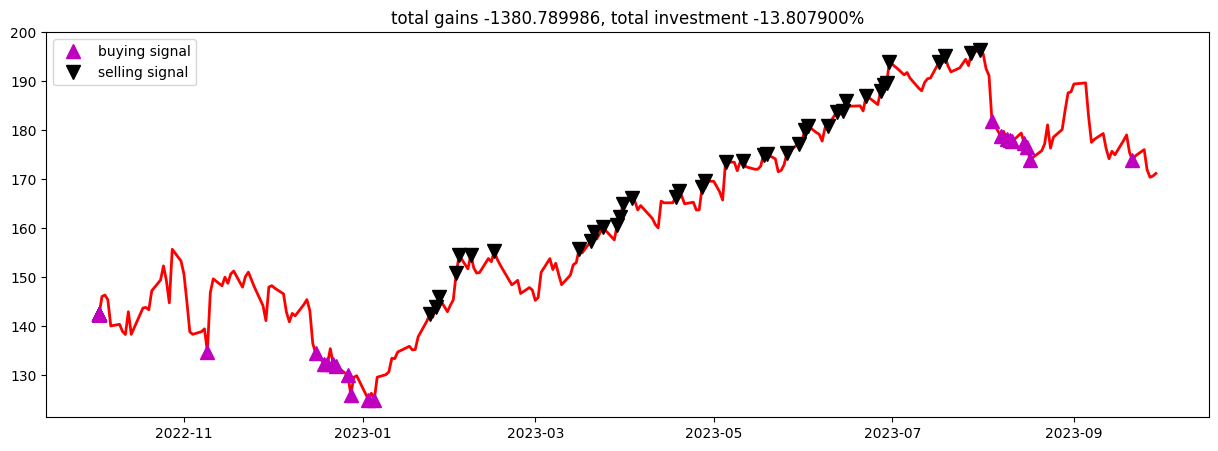

In [6]:
close = df['Close']
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()

# LSTM MODEL

In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
sns.set()
tf.compat.v1.random.set_random_seed(1234)

# ARIMA MODEL